# setup

In [2]:
# SRC: https://realpython.com/gradient-descent-algorithm-python/
%load_ext autoreload
%autoreload 2

from pprint import pprint
import numpy as np

from utils.visualization import plot


# Basic Gradient Descent


In [3]:
def GD(gradient, start, lr, n_iter=50, tolerance=1e-06):
    vector = start
    history_of_x = [vector]

    for _ in range(n_iter):
        diff = -lr * gradient(vector)
        history_of_x.append(history_of_x[-1] + diff)
        if np.all(np.abs(diff) <= tolerance):
            break

        vector += diff

    return vector, history_of_x

def GD_plot(gradient, start, lr, n_iter=50, tolerance=1e-06, *, f=None, X=np.linspace(-10, 10, 100)):
    vector, history_of_x = GD(gradient, start, lr, n_iter, tolerance)
    ys = [f, [(xi, f(xi)) for xi in history_of_x]]
    plot(ys, X)

    return vector, history_of_x

In [4]:
r = [
    GD(gradient=lambda v: 2 * v, start=10.0, lr=0.2),
    GD(gradient=lambda v: 2 * v, start=10.0, lr=0.2, n_iter=5),
    GD(gradient=lambda v: 2 * v, start=10.0, lr=0.8),
    GD(gradient=lambda v: 2 * v, start=10.0, lr=0.005),
    GD(gradient=lambda v: 2 * v, start=10.0, lr=0.005, n_iter=1000),
]

pprint([loss for loss, history in r])


[2.210739197207331e-06,
 0.7775999999999998,
 -4.77519666596786e-07,
 6.050060671375367,
 0.0004317124741065828]


/tmp/ipykernel_21745/283096867.py:9: RuntimeWarning: invalid value encountered in log
  def f3(x): return x - np.log(x)


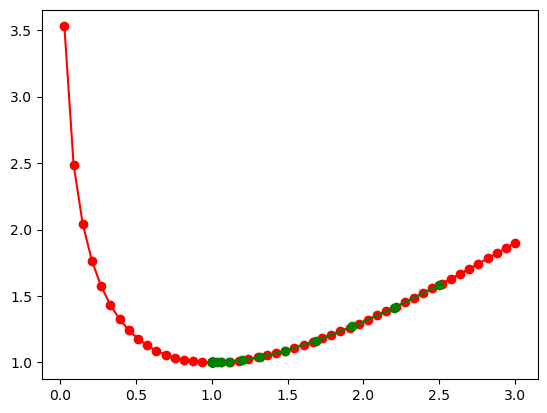

In [5]:
def f1(x): return x ** 2
def f1_d(x): return 2 * x
f1_X = np.linspace(-10, 10, 100)

def f2(x): return (x**4) - 5 * (x**2) - 3 * x
def f2_d(x): return 4 * (x**3) - 10 * x - 3
f2_X = np.linspace(-3, 3, 100)

def f3(x): return x - np.log(x)
def f3_d(x): return 1 - 1 / x
f3_X = np.linspace(-3, 3, 100)

combos = [
    # (f1, f1_d, f1_X, 10, 0.8),
    # (f1, f1_d, f1_X, 10, 0.2),
    # (f2, f2_d, f2_X, 0, 0.2),
    # (f2, f2_d, f2_X, 0, 0.1),
    (f3, f3_d, f3_X, 2.5, 0.5),
]
for f, fd, X, start, lr in combos:
    loss, x = GD_plot(gradient=fd, start=start, lr=lr, f=f, X=X)


In [6]:
def ssr_gradient(x, y, b):
    res = b[0] + b[1] * x - y
    return res.mean(), (res * x).mean()

def GD2(gradient, x, y, start, lr=0.1, n_iter=50, tolerance=1e-06, dtype="float64"):
    if not callable(gradient):
        raise TypeError("'gradient' must be callable")

    dtype_ = np.dtype(dtype)
    x, y = np.array(x, dtype=dtype_), np.array(y, dtype=dtype_)
    if x.shape[0] != y.shape[0]:
        raise ValueError("'x' and 'y' lengths do not match")

    vector = np.array(start, dtype=dtype_)
    lr = np.array(lr, dtype=dtype_)
    if np.any(lr <= 0):
        raise ValueError("'lr' must be greater than zero")

    n_iter = int(n_iter)
    if n_iter <= 0:
        raise ValueError("'n_iter' must be greater than zero")

    tolerance = np.array(tolerance, dtype=dtype_)
    if np.any(tolerance <= 0):
        raise ValueError("'tolerance' must be greater than zero")

    for _ in range(n_iter):
        diff = -lr * np.array(gradient(x, y, vector), dtype_)
        if np.all(np.abs(diff) <= tolerance):
            break

        vector += diff

    return vector if vector.shape else vector.item()

x = np.array([5, 15, 25, 35, 45, 55])
y = np.array([5, 20, 14, 32, 22, 38])

GD2(ssr_gradient, x, y, start=[0.5, 0.5], lr=0.0008, n_iter=100_000)


array([5.62822349, 0.54012867])

# SGD


In [7]:
def SGD(
    gradient, x, y, start, lr=0.1, batch_size=1, n_iter=50,
    tolerance=1e-06, dtype="float64", seed=None
):
    def setup_data(x, y, dtype_):
        x, y = np.array(x, dtype=dtype_), np.array(y, dtype=dtype_)
        n_obs = x.shape[0]
        if n_obs != y.shape[0]:
            raise ValueError("'x' and 'y' lengths do not match")

        xy = np.c_[x.reshape(n_obs, -1), y.reshape(n_obs, 1)]
        return x, y, xy, n_obs

    def setup_rng(seed):
        seed = None if seed is None else int(seed)
        return np.random.default_rng(seed=seed)

    def setup_lr(lr):
        lr = np.array(lr, dtype=dtype_)
        if np.all(lr > 0):
            return lr

        raise ValueError("'lr' must be greater than zero")

    def setup_bs(batch_size):
        batch_size = int(batch_size)
        if 0 < batch_size <= n_obs:
            return batch_size

        raise ValueError("'batch_size' must be greater than zero and less than or equal to the number of observations")

    def setup_number_of_iterations(n_iter):
        n_iter = int(n_iter)
        if n_iter <= 0:
            raise ValueError("'n_iter' must be greater than zero")
        return n_iter

    def setup_tolerance(dtype_, tolerance):
        tolerance = np.array(tolerance, dtype=dtype_)
        if np.any(tolerance <= 0):
            raise ValueError("'tolerance' must be greater than zero")
        return tolerance

    if not callable(gradient):
        raise TypeError("'gradient' must be callable")

    dtype_ = np.dtype(dtype)
    vector = np.array(start, dtype=dtype_)
    x, y, xy, n_obs = setup_data(x, y, dtype_)

    rng = setup_rng(seed)
    lr = setup_lr(lr)
    batch_size = setup_bs(batch_size)
    n_iter = setup_number_of_iterations(n_iter)
    tolerance = setup_tolerance(dtype_, tolerance)

    for _ in range(n_iter):
        rng.shuffle(xy)

        for start in range(0, n_obs, batch_size):
            stop = start + batch_size
            x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]

            grad = np.array(gradient(x_batch, y_batch, vector), dtype_)
            diff = -lr * grad

            if np.all(np.abs(diff) <= tolerance):
                break

            vector += diff

    return vector if vector.shape else vector.item()


SGD(ssr_gradient, x, y, start=[0.5, 0.5], lr=0.0008, batch_size=3, n_iter=100_000, seed=0)


array([5.63093736, 0.53982921])

# Momentum (decay_rate)


In [13]:
def SGD(
    gradient, x, y, n_vars=None, start=None, lr=0.1, decay_rate=0.0, batch_size=1, n_iter=50,
    tolerance=1e-06, dtype="float64", seed=None
):
    def setup_data(x, y, dtype_):
        x, y = np.array(x, dtype=dtype_), np.array(y, dtype=dtype_)
        n_obs = x.shape[0]
        if n_obs != y.shape[0]:
            raise ValueError("'x' and 'y' lengths do not match")

        xy = np.c_[x.reshape(n_obs, -1), y.reshape(n_obs, 1)]
        return x, y, xy, n_obs

    def setup_rng(seed):
        seed = None if seed is None else int(seed)
        return np.random.default_rng(seed=seed)

    def setup_vector(dtype_, n_vars, rng, start):
        vector = (
            rng.normal(size=int(n_vars)).astype(dtype_)
            if start is None else
            np.array(start, dtype=dtype_)
        )
        return vector

    def setup_lr(lr):
        lr = np.array(lr, dtype=dtype_)
        if np.all(lr > 0):
            return lr

        raise ValueError("'lr' must be greater than zero")

    def setup_decay(decay_rate):
        decay_rate = np.array(decay_rate, dtype=dtype_)
        if not np.all(0 <= decay_rate <= 1):
            raise ValueError("'decay_rate' must be between zero and one")

        return decay_rate

    def setup_bs(batch_size):
        batch_size = int(batch_size)
        if 0 < batch_size <= n_obs:
            return batch_size

        raise ValueError("'batch_size' must be greater than zero and less than or equal to the number of observations")

    def setup_number_of_iterations(n_iter):
        n_iter = int(n_iter)
        if n_iter <= 0:
            raise ValueError("'n_iter' must be greater than zero")
        return n_iter

    def setup_tolerance(dtype_, tolerance):
        tolerance = np.array(tolerance, dtype=dtype_)
        if np.any(tolerance <= 0):
            raise ValueError("'tolerance' must be greater than zero")
        return tolerance

    if not callable(gradient):
        raise TypeError("'gradient' must be callable")

    dtype_ = np.dtype(dtype)
    x, y, xy, n_obs = setup_data(x, y, dtype_)

    rng = setup_rng(seed)
    vector = setup_vector(dtype_, n_vars, rng, start)

    lr = setup_lr(lr)
    decay_rate = setup_decay(decay_rate)
    batch_size = setup_bs(batch_size)
    n_iter = setup_number_of_iterations(n_iter)
    tolerance = setup_tolerance(dtype_, tolerance)
    diff = 0

    for _ in range(n_iter):
        rng.shuffle(xy)

        for start in range(0, n_obs, batch_size):
            stop = start + batch_size
            x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]

            grad = np.array(gradient(x_batch, y_batch, vector), dtype_)
            diff = decay_rate * diff - lr * grad

            if np.all(np.abs(diff) <= tolerance):
                break

            vector += diff

    return vector if vector.shape else vector.item()


SGD(ssr_gradient, x, y, n_vars=2, lr=0.0001, decay_rate=0.8, batch_size=3, n_iter=100_000, seed=0)


array([5.63014443, 0.53901017])